In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.signal import hilbert
from time import time 
from mne.filter import filter_data as filter

## Creating Signal - e.g. Alpha (Carrier Freq 10 hz)

Sets up a matrix of three signals each with the same frequency components, but shifted by a few milliseconds/seconds.
The second half of the signals is replaced by noise to see if the Metastability function works. 

Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 165 samples (1.650 sec)

Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Fi

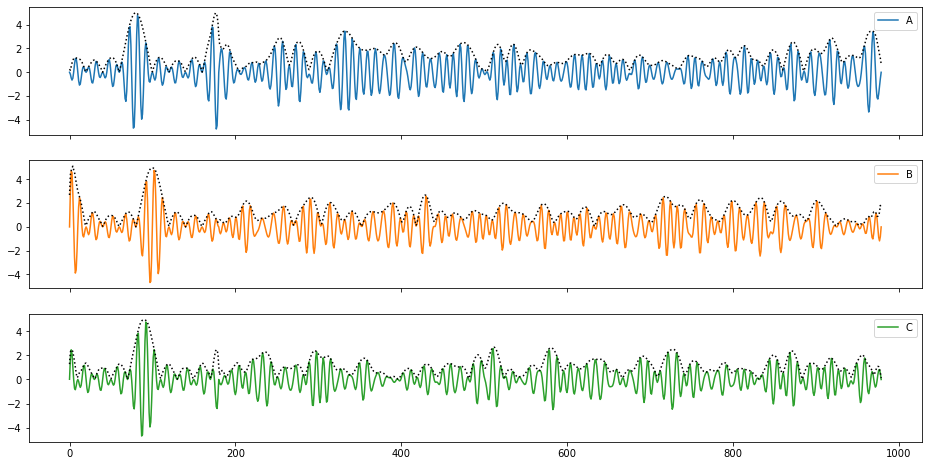

In [2]:
def create_signal(noise=2):
    # Set up signal parameters
    timepoints = 1000 # number of timepoints
    totaltime = 10 # in seconds
    fsample = timepoints/totaltime
    carrier_freq = 10 # in hz
    shift = 0.2 # in seconds

    # Define signal as 4 sine waves with frequencies +/- 2 hz of the carrier freq
    t = np.linspace(0,totaltime,timepoints)

    s = np.zeros(timepoints)
    for i in np.arange(-2,3,1):   
        s += np.sin((carrier_freq+i)*t*2*np.pi)

    # shifting signal in range of seconds
    shift = int(shift*fsample)
    a = s[shift:].copy()
    b = s[:-shift].copy()
    c = s[shift//2:-shift//2].copy()

    # set second half of the signal to noise
    noise_timepoints = noise
    a[-noise_timepoints:] = filter(np.random.rand(noise_timepoints)*10, fsample, carrier_freq-2, carrier_freq+2)
    b[-noise_timepoints:] = filter(np.random.rand(noise_timepoints)*10, fsample, carrier_freq-2, carrier_freq+2)
    c[-noise_timepoints:] = filter(np.random.rand(noise_timepoints)*10, fsample, carrier_freq-2, carrier_freq+2)
    signals = np.stack([a,b,c])

    # calculate analytic signal and envelope
    analytic_signals = hilbert(signals, axis=-1)
    envelopes = np.abs(analytic_signals)

    # Plot 
    colors = ['tab:blue', 'tab:orange', 'tab:green']
    names = ['A','B','C']
    fig, axes = plt.subplots(3,1,figsize=(16,8), sharex=True)
    for n,ax in enumerate(axes.flat): 
        ax.plot(signals[n,:], color=colors[n],label=names[n])
        ax.plot(envelopes[n,:], ':k')
        ax.legend(loc='upper right')
    return envelopes, fsample, names

# Run Function
envelopes, fsample, names = create_signal(noise=800)

## Lowpass and demean Envelopes

Setting up low-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 165 samples (1.650 sec)



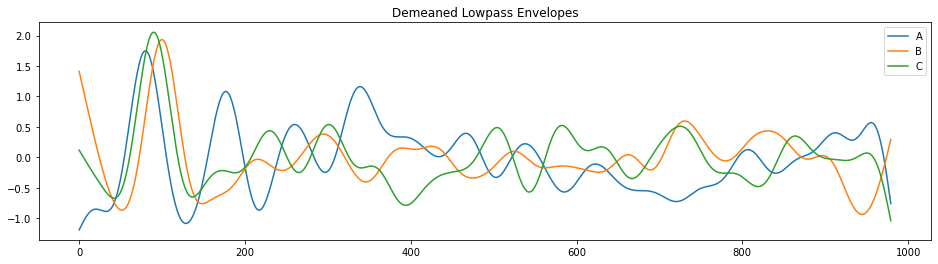

In [3]:
# Demean Envelopes
d_envelopes = envelopes - np.mean(envelopes, axis=-1, keepdims=True)

# Lowpass filter envelope
lowpassfreq = 0.5
dl_envelopes = filter(d_envelopes, fsample, 0, lowpassfreq)

# Plot 
fig, axes = plt.subplots(figsize=(16,4))
axes.set_title('Demeaned Lowpass Envelopes')
for n, envelope in enumerate(dl_envelopes): 
    axes.plot(envelope, label=names[n])
    axes.legend(loc='upper right')

# Define Metastability Function

In [8]:
def meta(signal):
    # Compute the phase of signal 
    analytic = hilbert(signal, axis=-1)
    phase = np.angle(analytic)
    ImPhase = phase * 1j
    SumPhase = np.sum(np.exp(ImPhase), axis=0) 
    # Compute kuramoto parameter
    Kuramoto = np.abs(SumPhase) / ImPhase.shape[0]  
    Metastability = np.std(Kuramoto, axis=-1)
    return Kuramoto, Metastability, phase

Text(900, 0.9, 'Metastability: 0.2')

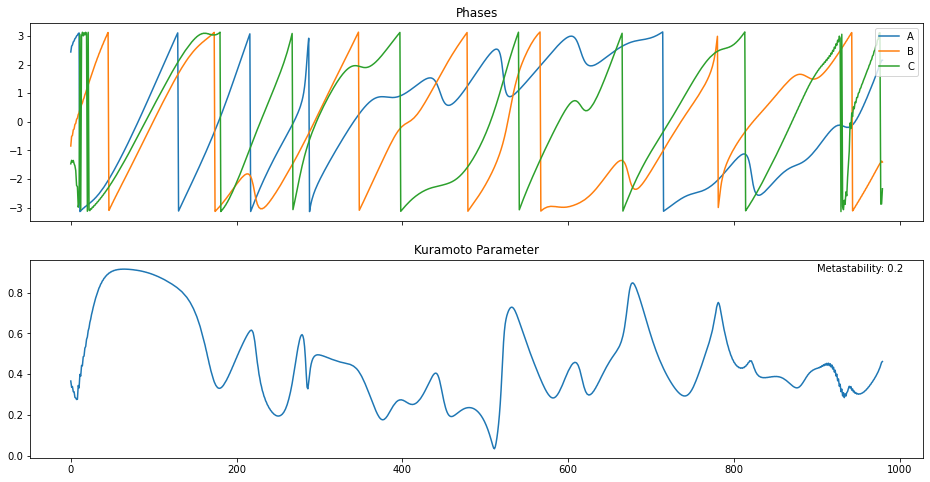

In [9]:
kuramoto, metastability, phases = meta(dl_envelopes)

# Plot 
fig, axes = plt.subplots(2, 1, figsize=(16,8), sharex=True)
axes[0].set_title('Phases')
for n, phase in enumerate(phases): 
    axes[0].plot(phase, label=names[n])
    axes[0].legend(loc='upper right')

axes[1].set_title('Kuramoto Parameter')
axes[1].plot(kuramoto)
axes[1].text(x=900, y=0.9, s=f'Metastability: {np.round(metastability,2)}')